## 1)下载ISBI Challenge数据集到本地：https://www.kaggle.com/code/kerneler/starter-isbi-challenge-dataset-21087002-9/data

30


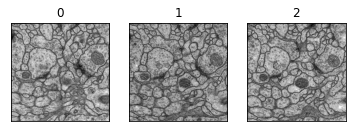

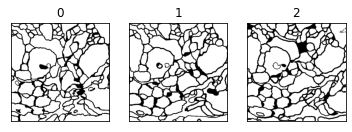

In [28]:
import os
from collections import deque
import multiprocessing
import cv2
from matplotlib import pyplot as plt
import math
import numpy as np
from PIL import Image, ImageSequence
import mindspore.dataset as ds
import mindspore.dataset.vision as c_vision
from mindspore.dataset.vision.utils import Inter
from mindspore.communication.management import get_rank, get_group_size

#显示下载好的数据
train_image_path = "data/train-volume.tif"
train_masks_path = "data/train-labels.tif"
image = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_image_path))])
masks = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_masks_path))])

def show_image(image_list,num = 6):
    '''
    #image_list: 图像序列，numpy数组
    #num: 显示图片的数量
    '''
    img_titles = []
    img_draws = []
    for ind,img in enumerate(image_list):
        if ind == num:
            break
        img_titles.append(ind)
        img_draws.append(img)

    for i in range(len(img_titles)):
        if len(img_titles) > 6:
            row = 3
        elif 3<len(img_titles)<=6:
            row = 2
        else:
            row = 1
        col = math.ceil(len(img_titles)/row)
        plt.subplot(row,col,i+1),plt.imshow(img_draws[i],'gray')
        plt.title(img_titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
show_image(image,num = 3)
show_image(masks,num = 3)

## 切片图片保存到本地

In [4]:
import cv2
import numpy as np
import skimage.io as io
train_image_path = "data/train-volume.tif"
train_masks_path = "data/train-labels.tif"
test_image_path = "data/test-volume.tif"
image = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_image_path))])
masks = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(train_masks_path))])
test = np.array([np.array(p) for p in ImageSequence.Iterator(Image.open(test_image_path))])

for i in range(image.shape[0]):
    io.imsave(os.path.join("src/datasets/train_imgs", "%05d.png" % i), image[i])
    io.imsave(os.path.join("src/datasets/train_mask", "%05d.png" % i), masks[i])
    
for i in range(test.shape[0]):
    io.imsave(os.path.join("src/datasets/test_imgs", "%05d.png" % i), test[i])


## 2）创建数据集 (先将本地数据划分2:1)

In [6]:
import os
import cv2
import numpy as np
import mindspore.dataset as ds
import glob
import albumentations as A

def train_transforms(img_size):
    return A.Compose([
            # A.RandomResizedCrop(img_size, img_size),
            A.Resize(img_size, img_size),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.ShiftScaleRotate(p=0.25),
            A.RandomRotate90(p=0.25),
            ], p=1.)

def val_transforms(img_size):
    return A.Compose([
            A.Resize(img_size, img_size),
            ], p=1.)


class Data_Loader:
    def __init__(self, data_path, image_size=None, aug=True):
        # 初始化函数，读取所有data_path下的图片
        self.image_size = image_size
        self.aug = aug
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png'))
        self.label_path = glob.glob(os.path.join(data_path, 'mask/*.png'))
        self.train_aug = train_transforms(image_size)
        self.test_aug = val_transforms(image_size)

    def __getitem__(self, index):
        # 根据index读取图片
        image = cv2.imread(self.imgs_path[index])
        label = cv2.imread(self.label_path[index], cv2.IMREAD_GRAYSCALE)

        if self.aug:
            augments = self.train_aug(image=image, mask=label)
            image, label = augments['image'], augments['mask']
        else:
            augments = self.test_aug(image=image, mask=label)
            image, label = augments['image'], augments['mask']

        image = np.transpose(image, (2, 0, 1))
        label = np.reshape(label, (1, self.image_size, self.image_size))

        image = image / 255.
        label = label / 255.

        return image.astype("float32"), label.astype("float32")

    @property
    def column_names(self):
        column_names = ['image', 'label']
        return column_names

    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)


def create_dataset(data_dir, img_size, batch_size, augment, shuffle):
    mc_dataset = Data_Loader(data_path=data_dir, image_size=img_size, aug=augment)
    dataset = ds.GeneratorDataset(mc_dataset, mc_dataset.column_names, shuffle=shuffle)
    dataset = dataset.batch(batch_size, num_parallel_workers=1)
    if augment==True and shuffle==True:
        print("训练集数据量：", len(mc_dataset))
    elif augment==False and shuffle==False:
        print("验证集数据量：", len(mc_dataset))
    else:
        pass

    return dataset

In [7]:
train_dataset = create_dataset("src/datasets/ISBI/train/", img_size=224, batch_size= 5, augment=True, shuffle=True)
for image, label in train_dataset:
    print(image.shape,label.shape)

训练集数据量： 20
(5, 3, 224, 224) (5, 1, 224, 224)
(5, 3, 224, 224) (5, 1, 224, 224)
(5, 3, 224, 224) (5, 1, 224, 224)
(5, 3, 224, 224) (5, 1, 224, 224)


## 3）构建U-Net框架

In [8]:
from mindspore import nn
import mindspore.numpy as np
from mindspore import Tensor
import mindspore.ops as ops

class double_conv(nn.Cell):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.double_conv = nn.SequentialCell(nn.Conv2d(in_ch, out_ch, 3),
                                             nn.BatchNorm2d(out_ch), nn.ReLU(),
                                             nn.Conv2d(out_ch, out_ch, 3),
                                             nn.BatchNorm2d(out_ch), nn.ReLU())

    def construct(self, x):
        x = self.double_conv(x)
        return x


class UNet(nn.Cell):
    def __init__(self, in_ch = 3, n_classes = 1):
        super(UNet, self).__init__()
        # Encoder
        # [N,3,224,224]->[N,64,224,224]
        self.double_conv1 = double_conv(in_ch, 64)
        # [N,64,224,224]->[N,64,112,112]
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,64,112,112]->[N,128,112,112]
        self.double_conv2 = double_conv(64, 128)
        # [N,128,112,112]->[N,128,56,56]
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,128,56,56]->[N,256,56,56]
        self.double_conv3 = double_conv(128, 256)
        # [N,256,56,56]->[N,256,28,28]
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,256,28,28]->[N,512,28,28]
        self.double_conv4 = double_conv(256, 512)
        # [N,512,28,28]->[N,512,14,14]
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # [N,512,14,14]->[N,1024,14,14]
        self.double_conv5 = double_conv(512, 1024)

        # Decoder
        # [N,1024,14,14]->[N,1024,28,28]
        self.upsample1 = nn.ResizeBilinear()
        # [N,1024+512,28,28]->[N,512,28,28]
        self.double_conv6 = double_conv(1024 + 512, 512)
        # [N,512,28,28]->[N,512,56,56]
        self.upsample2 = nn.ResizeBilinear()
        # [N,512+256,56,56]->[N,256,56,56]
        self.double_conv7 = double_conv(512 + 256, 256)
        # [N,256,56,56]->[N,256,112,112]
        self.upsample3 = nn.ResizeBilinear()
        # [N,256+128,112,112]->[N,128,112,112]
        self.double_conv8 = double_conv(256 + 128, 128)
        # [N,128,112,112]->[N,128,224,224]
        self.upsample4 = nn.ResizeBilinear()
        # [N,128+64,224,224]->[N,64,224,224]
        self.double_conv9 = double_conv(128 + 64, 64)

        self.final = nn.Conv2d(64, n_classes, 1)
        self.sigmoid = ops.Sigmoid()

    def construct(self, x):

        feature1 = self.double_conv1(x)
        tmp = self.maxpool1(feature1)
        feature2 = self.double_conv2(tmp)
        tmp = self.maxpool2(feature2)
        feature3 = self.double_conv3(tmp)
        tmp = self.maxpool3(feature3)
        feature4 = self.double_conv4(tmp)
        tmp = self.maxpool4(feature4)
        feature5 = self.double_conv5(tmp)

        up_feature1 = self.upsample1(feature5, scale_factor=2)
        tmp = np.concatenate((feature4, up_feature1), axis=1)
        tmp = self.double_conv6(tmp)
        up_feature2 = self.upsample2(tmp, scale_factor=2)
        tmp = np.concatenate((feature3, up_feature2), axis=1)
        tmp = self.double_conv7(tmp)
        up_feature3 = self.upsample3(tmp, scale_factor=2)
        tmp = np.concatenate((feature2, up_feature3), axis=1)
        tmp = self.double_conv8(tmp)
        up_feature4 = self.upsample4(tmp, scale_factor=2)
        tmp = np.concatenate((feature1, up_feature4), axis=1)
        tmp = self.double_conv9(tmp)
        output = self.sigmoid(self.final(tmp))

        return output

# import mindspore as ms
# x = Tensor(np.zeros([2, 3, 224, 224]), ms.float32)
# model = UNet()
# out = model(x)
# print(out.shape)

In [9]:
import mindspore as ms
x = Tensor(np.zeros([2, 3, 224, 224]), ms.float32)
model = UNet()
out = model(x)

print("模型输入:", x.shape)
print("模型输出:", out.shape)

模型输入: (2, 3, 224, 224)
模型输出: (2, 1, 224, 224)


## 4）自定义metrics

In [10]:
import numpy as np
from mindspore._checkparam import Validator as validator
from mindspore.nn.metrics import *
from mindspore import Tensor
from mindspore.nn import Metric


def _convert_data(data):

    if isinstance(data, Tensor):
        data = data.asnumpy()
    elif isinstance(data, list):
        data = np.array(data)
    elif isinstance(data, np.ndarray):
        pass
    else:
        raise TypeError(f"For 'Metric' and its derived classes, the input data type must be tensor, list or "
                        f"numpy.ndarray, but got {type(data)}.")
    return data


class metrics_(Metric):

    def __init__(self, metrics, smooth=1e-5):
        super(metrics_, self).__init__()
        self.metrics = metrics
        self.smooth = validator.check_positive_float(smooth, "smooth")
        self.metrics_list = [0. for i in range(len(self.metrics))]
        self._samples_num = 0
        self.clear()

    def Acc_metrics(self,y_pred, y):
        tp = np.sum(y_pred.flatten() == y.flatten(), dtype=y_pred.dtype)
        total = len(y_pred.flatten())
        single_acc = float(tp) / float(total)
        return single_acc

    def IoU_metrics(self,y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten() + y.flatten()) - intersection
        single_iou = float(intersection) / float(unionset + self.smooth)
        return single_iou

    def Dice_metrics(self,y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten()) + np.sum(y.flatten())
        single_dice = 2*float(intersection) / float(unionset + self.smooth)
        return single_dice

    def Sens_metrics(self,y_pred, y):
        tp = np.sum(y_pred.flatten() * y.flatten())
        actual_positives = np.sum(y.flatten())
        single_sens = float(tp) / float(actual_positives + self.smooth)
        return single_sens

    def Spec_metrics(self,y_pred, y):
        true_neg = np.sum((1 - y.flatten()) * (1 - y_pred.flatten()))
        total_neg = np.sum((1 - y.flatten()))
        single_spec = float(true_neg) / float(total_neg + self.smooth)
        return single_spec

    def clear(self):
        """Clears the internal evaluation result."""
        self.metrics_list = [0. for i in range(len(self.metrics))]
        self._samples_num = 0

    def update(self, *inputs):

        if len(inputs) != 2:
            raise ValueError("For 'update', it needs 2 inputs (predicted value, true value), "
                             "but got {}.".format(len(inputs)))

        y_pred = np.round(_convert_data(inputs[0]))

        y = _convert_data(inputs[1])

        self._samples_num += y.shape[0]

        if y_pred.shape != y.shape:
            raise ValueError(f"For 'update', predicted value (input[0]) and true value (input[1]) "
                             f"should have same shape, but got predicted value shape: {y_pred.shape}, "
                             f"true value shape: {y.shape}.")

        for i in range(y.shape[0]):
            if "acc" in self.metrics:
                single_acc = self.Acc_metrics(y_pred[i], y[i])
                self.metrics_list[0] += single_acc
            if "iou" in self.metrics:
                single_iou = self.IoU_metrics(y_pred[i], y[i])
                self.metrics_list[1] += single_iou
            if "dice" in self.metrics:
                single_dice = self.Dice_metrics(y_pred[i], y[i])
                self.metrics_list[2] += single_dice
            if "sens" in self.metrics:
                single_sens = self.Sens_metrics(y_pred[i], y[i])
                self.metrics_list[3] += single_sens
            if "spec" in self.metrics:
                single_spec = self.Spec_metrics(y_pred[i], y[i])
                self.metrics_list[4] += single_spec


    def eval(self):

        if self._samples_num == 0:
            raise RuntimeError("The 'metrics' can not be calculated, because the number of samples is 0, "
                               "please check whether your inputs(predicted value, true value) are empty, or has "
                               "called update method before calling eval method.")
        for i in range(len(self.metrics_list)):
            self.metrics_list[i] = self.metrics_list[i] / float(self._samples_num)

        return self.metrics_list


In [11]:
# mindspore.numpy.rint 四舍五入
x = Tensor(np.array([[[[0.2, 0.5, 0.7], [0.3, 0.1, 0.2], [0.9, 0.6, 0.8]]]]))
y = Tensor(np.array([[[[0, 1, 1], [1, 0, 0], [0, 1, 1]]]]))
metric = metrics_(["acc", "iou", "dice", "sens", "spec"],smooth=1e-5)
metric.clear()
metric.update(x, y)
res = metric.eval()
print( '丨acc: %.4f丨丨iou: %.4f丨丨dice: %.4f丨丨sens: %.4f丨丨spec: %.4f丨' % (res[0], res[1], res[2], res[3],res[4]), flush=True)

丨acc: 0.6667丨丨iou: 0.5000丨丨dice: 0.6667丨丨sens: 0.6000丨丨spec: 0.7500丨


## 5）自定义回调机制

In [15]:
from mindspore.train.callback import Callback
from mindspore import nn
from mindspore.ops import operations as ops
import os
import stat
from mindspore import save_checkpoint
from mindspore import log as logger

class TempLoss(nn.Cell):
    """A temp loss cell."""

    def __init__(self):
        super(TempLoss, self).__init__()
        self.identity = ops.identity()

    def construct(self, logits, label):
        return self.identity(logits)

def apply_eval(eval_param_dict):
    """run Evaluation"""
    model = eval_param_dict["model"]
    dataset = eval_param_dict["dataset"]
    metrics_name = eval_param_dict["metrics_name"]
    eval_score = model.eval(dataset, dataset_sink_mode=False)[metrics_name]
    return eval_score


class EvalCallBack(Callback):

    def __init__(self, eval_function, eval_param_dict, interval=1, eval_start_epoch=1, save_best_ckpt=True,
                 ckpt_directory="./", besk_ckpt_name="best.ckpt", monitor="IoU", flag = "Train"):
        super(EvalCallBack, self).__init__()
        self.eval_param_dict = eval_param_dict
        self.eval_function = eval_function
        self.eval_start_epoch = eval_start_epoch
        if interval < 1:
            raise ValueError("interval should >= 1.")
        self.interval = interval
        self.save_best_ckpt = save_best_ckpt
        self.best_res = 0
        self.best_epoch = 0
        if not os.path.isdir(ckpt_directory):
            os.makedirs(ckpt_directory)
        self.bast_ckpt_path = os.path.join(ckpt_directory, besk_ckpt_name)
        self.monitor_name = monitor
        self.flag = flag
        
    def remove_ckpoint_file(self, file_name):
        """Remove the specified checkpoint file from this checkpoint manager and also from the directory."""
        try:
            os.chmod(file_name, stat.S_IWRITE)
            os.remove(file_name)
        except OSError:
            logger.warning("OSError, failed to remove the older ckpt file %s.", file_name)
        except ValueError:
            logger.warning("ValueError, failed to remove the older ckpt file %s.", file_name)

    def epoch_end(self, run_context):
        """Callback when epoch end."""
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num

        if cur_epoch >= self.eval_start_epoch and (cur_epoch - self.eval_start_epoch) % self.interval == 0:
            res = self.eval_function(self.eval_param_dict)

            print("epoch: {} {}_metrics:".format(cur_epoch, self.flag), '丨acc: %.4f丨丨iou: %.4f丨丨dice: %.4f丨丨sens: %.4f丨丨spec: %.4f丨' %
                  (res[0], res[1], res[2], res[3],res[4]), flush=True)

            if self.flag != "train":
                if res[1] > self.best_res:
                    print('IoU improved from %0.4f to %0.4f' % (self.best_res, res[1]), flush=True)
                    self.best_res = res[1]
                    self.best_epoch = cur_epoch

                    if self.save_best_ckpt:
                        if os.path.exists(self.bast_ckpt_path):
                            self.remove_ckpoint_file(self.bast_ckpt_path)
                        save_checkpoint(cb_params.train_network, self.bast_ckpt_path)
                        print("saving best checkpoint at: {} ".format(self.bast_ckpt_path), flush=True)
                else:
                    print('IoU did not improve from %0.4f' % (self.best_res))
                    
                print("="*100)


    def end(self, run_context):
        print("End training, the best {0} is: {1}, the best {0} epoch is {2}".format(self.monitor_name,
                                                                                     self.best_res,
                                                                                     self.best_epoch), flush=True)

## 6）训练U-Net和评估

In [24]:
import ml_collections

def get_config():
    """configuration """
    config = ml_collections.ConfigDict()
    config.epochs = 20
    config.train_data_path = "src/datasets/ISBI/train/"
    config.val_data_path = "src/datasets/ISBI/val/"
    config.imgsize = 224
    config.batch_size = 4
    config.pretrained_path = None
    config.in_channel = 3
    config.n_classes = 1
    config.lr = 0.00001
    return config


In [25]:
from src.metric import metrics_
from src.eval_callback import TempLoss,EvalCallBack, apply_eval
from src.UNet_model import UNet
import mindspore.nn as nn
from mindspore.train.callback import LossMonitor, TimeMonitor, ModelCheckpoint, CheckpointConfig
from mindspore import Model
from src.data_loader import create_dataset
from mindspore.train.loss_scale_manager import FixedLossScaleManager

cfg = get_config()

train_dataset = create_dataset(cfg.train_data_path, img_size=cfg.imgsize, batch_size= cfg.batch_size, augment=True, shuffle = True)
val_dataset = create_dataset(cfg.val_data_path, img_size=cfg.imgsize, batch_size= cfg.batch_size, augment=False, shuffle = False)


iters_per_epoch = train_dataset.get_dataset_size()
total_train_steps = iters_per_epoch * cfg.epochs
print('iters_per_epoch: ', iters_per_epoch)
print('total_train_steps: ', total_train_steps)

criterion = nn.BCELoss()
criterion.add_flags_recursive(fp32=True)

net = UNet(cfg.in_channel, cfg.n_classes)
manager_loss_scale = FixedLossScaleManager(drop_overflow_update=False)

optimizer = nn.SGD(params=net.trainable_params(), learning_rate=cfg.lr)

metrics_name = ["acc", "iou", "dice", "sens", "spec"]

model = Model(net,
              optimizer=optimizer,
              amp_level="O0",
              loss_fn=criterion,
              loss_scale_manager=None,
              metrics={'metrics':metrics_(metrics_name, smooth=1e-5)})

time_cb = TimeMonitor(data_size=iters_per_epoch)
loss_cb = LossMonitor(per_print_times = iters_per_epoch)

# config_ckpt = CheckpointConfig(save_checkpoint_steps=iters_per_epoch, keep_checkpoint_max=5)
# cbs_1 = ModelCheckpoint(prefix="UNet", directory='checkpoint', config=config_ckpt)

eval_param_dict_train = {"model": model, "dataset": train_dataset, "metrics_name": 'metrics'}
eval_cb_train = EvalCallBack(apply_eval, eval_param_dict_train,
                       interval=1, eval_start_epoch=1,
                       save_best_ckpt=False, ckpt_directory="src/checkpoint",
                       besk_ckpt_name="best.ckpt", monitor= "IoU", flag = 'train')  # monitor


eval_param_dict_val = {"model": model, "dataset": val_dataset, "metrics_name": 'metrics'}
eval_cb_val = EvalCallBack(apply_eval, eval_param_dict_val,
                       interval=1, eval_start_epoch=1,
                       save_best_ckpt=True, ckpt_directory="src/checkpoint",
                       besk_ckpt_name="best.ckpt", monitor= "IoU", flag = 'val')  # monitor

cbs = [time_cb, loss_cb, eval_cb_train, eval_cb_val]

model.train(cfg.epochs, train_dataset, callbacks=cbs)



训练集数据量： 20
验证集数据量： 10
iters_per_epoch:  5
total_train_steps:  100


[WARNING] ME(65248:61672,MainProcess):2022-08-21-20:49:03.245.624 [mindspore\train\model.py:536] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


epoch: 1 step: 5, loss is 0.47953054308891296
epoch time: 31360.105 ms, per step time: 6272.021 ms
epoch: 1 train_metrics: 丨acc: 0.7794丨丨iou: 0.7794丨丨dice: 0.8758丨丨sens: 1.0000丨丨spec: 0.0000丨
epoch: 1 val_metrics: 丨acc: 0.7809丨丨iou: 0.7809丨丨dice: 0.8768丨丨sens: 1.0000丨丨spec: 0.0000丨
IoU improved from 0.0000 to 0.7809
saving best checkpoint at: src/checkpoint\best.ckpt 
epoch: 2 step: 5, loss is 0.42666640877723694
epoch time: 27057.993 ms, per step time: 5411.599 ms
epoch: 2 train_metrics: 丨acc: 0.7800丨丨iou: 0.7799丨丨dice: 0.8761丨丨sens: 1.0000丨丨spec: 0.0002丨
epoch: 2 val_metrics: 丨acc: 0.7810丨丨iou: 0.7809丨丨dice: 0.8768丨丨sens: 1.0000丨丨spec: 0.0000丨
IoU improved from 0.7809 to 0.7809
saving best checkpoint at: src/checkpoint\best.ckpt 
epoch: 3 step: 5, loss is 0.345596581697464
epoch time: 26628.739 ms, per step time: 5325.748 ms
epoch: 3 train_metrics: 丨acc: 0.7799丨丨iou: 0.7799丨丨dice: 0.8761丨丨sens: 0.9998丨丨spec: 0.0007丨
epoch: 3 val_metrics: 丨acc: 0.7810丨丨iou: 0.7809丨丨dice: 0.8768丨丨sens:

epoch time: 26606.021 ms, per step time: 5321.204 ms
epoch: 19 train_metrics: 丨acc: 0.8674丨丨iou: 0.8476丨丨dice: 0.9174丨丨sens: 0.9474丨丨spec: 0.5839丨
epoch: 19 val_metrics: 丨acc: 0.8767丨丨iou: 0.8580丨丨dice: 0.9235丨丨sens: 0.9552丨丨spec: 0.5942丨
IoU improved from 0.8576 to 0.8580
saving best checkpoint at: src/checkpoint\best.ckpt 
epoch: 20 step: 5, loss is 0.2882460653781891
epoch time: 25971.545 ms, per step time: 5194.309 ms
epoch: 20 train_metrics: 丨acc: 0.8437丨丨iou: 0.8196丨丨dice: 0.9007丨丨sens: 0.9121丨丨spec: 0.5997丨
epoch: 20 val_metrics: 丨acc: 0.8616丨丨iou: 0.8402丨丨dice: 0.9131丨丨sens: 0.9320丨丨spec: 0.6075丨
IoU did not improve from 0.8580
End training, the best IoU is: 0, the best IoU epoch is 0
End training, the best IoU is: 0.8579518266234739, the best IoU epoch is 19


## 7）模型预测

In [26]:
import cv2
from src.UNet_model import UNet
import mindspore as ms
import numpy as np
import matplotlib.pyplot as plt
from src.data_loader import create_dataset, val_transforms
import mindspore.ops as ops
import os
import skimage.io as io
from tqdm import tqdm
import albumentations as A
import glob
import mindspore.dataset as ds
from skimage import img_as_ubyte

class No_mask_Data_Loader:
    def __init__(self, data_path, image_size=None, aug=True):
        # 初始化函数，读取所有data_path下的图片
        self.image_size = image_size
        self.aug = aug
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, '*.png'))
        self.test_aug = val_transforms(image_size)

    def __getitem__(self, index):
        # 根据index读取图片
        image = cv2.imread(self.imgs_path[index])
        augments = self.test_aug(image=image, mask=image)
        image, label = augments['image'], augments['mask']
        image = np.transpose(image, (2, 0, 1))
        image = image / 255.
        label = image
        return image.astype("float32"),label.astype("float32")

    @property
    def column_names(self):
        column_names = ['image','label']
        return column_names

    def __len__(self):
        # 返回训练集大小
        return len(self.imgs_path)


def caculate_metrics(metrics, preds, gts, smooth=1e-5):
    pred = np.squeeze(preds.asnumpy())
    gt = np.squeeze(gts.asnumpy())

    metrics_list = [0. for i in range(len(metrics))]

    def Acc_metrics(y_pred, y):
        tp = np.sum(y_pred.flatten() == y.flatten())
        total = len(y_pred.flatten())
        single_acc = float(tp) / float(total)
        return single_acc

    def IoU_metrics(y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten() + y.flatten()) - intersection
        single_iou = float(intersection) / float(unionset + smooth)
        return single_iou

    def Dice_metrics(y_pred, y):
        intersection = np.sum(y_pred.flatten() * y.flatten())
        unionset = np.sum(y_pred.flatten()) + np.sum(y.flatten())
        single_dice = 2*float(intersection) / float(unionset + smooth)
        return single_dice

    def Sens_metrics(y_pred, y):
        tp = np.sum(y_pred.flatten() * y.flatten())
        actual_positives = np.sum(y.flatten())
        single_sens = float(tp) / float(actual_positives + smooth)
        return single_sens

    def Spec_metrics(y_pred, y):
        true_neg = np.sum((1 - y.flatten()) * (1 - y_pred.flatten()))
        total_neg = np.sum((1 - y.flatten()))
        single_spec = float(true_neg) / float(total_neg + smooth)
        return single_spec

    if "acc" in metrics:
        metrics_list[0] = Acc_metrics(pred, gt)

    if "iou" in metrics:
        metrics_list[1] = IoU_metrics(pred, gt)

    if "dice" in metrics:
        metrics_list[2] = Dice_metrics(pred, gt)

    if "sens" in metrics:
        metrics_list[3] = Sens_metrics(pred, gt)

    if "spec" in metrics:
        metrics_list[4] = Spec_metrics(pred, gt)

    return metrics_list


def model_pred(model, test_loader, result_path, Have_Mask = False):

    mtr = ['acc', 'iou', 'dice', 'sens', 'spec']
    metrics_list = [0. for i in range(len(mtr))]
    samples_num = 0

    for i, (image,  label) in enumerate(tqdm(test_loader)):
        samples_num += 1

        preds = model(image)

        if preds.min() < 0:
            preds = ops.Sigmoid()(preds)

        preds[preds > 0.5] = float(1)
        preds[preds <= 0.5] = float(0)

        if Have_Mask:
            for item in range(len(mtr)):
                metrics_list[item] += caculate_metrics(mtr, preds, label)[item]

        preds = np.squeeze(preds,axis=0)

        img = np.transpose(preds,(1,2,0))

        if not os.path.exists(result_path):
            os.makedirs(result_path)

        io.imsave(os.path.join(result_path, "%05d.png" % i), img_as_ubyte(img.asnumpy()))


    if Have_Mask:
        print('%s:丨acc: %.4f丨丨iou: %.4f丨丨dice: %.4f丨丨sens: %.4f丨丨spec: %.4f丨' %
              ("Test", metrics_list[0]/samples_num, metrics_list[1]/samples_num, metrics_list[2]/samples_num, metrics_list[3]/samples_num, metrics_list[4]/samples_num))

    else:
        print("Evaluation metrics cannot be calculated without Mask")


def load_test_data(data_dir, img_size, batch_size, augment, shuffle, Have_Mask = False):
    
    if Have_Mask:
        test_dataset = create_dataset(data_dir, img_size=img_size, batch_size=batch_size, augment=augment, shuffle=shuffle)
        
    else:
        mc_dataset = No_mask_Data_Loader(data_path=data_dir, image_size=img_size, aug=augment)
        print("测试集数据量：", len(mc_dataset))
        test_dataset = ds.GeneratorDataset(mc_dataset, mc_dataset.column_names, shuffle=shuffle)
        test_dataset = test_dataset.batch(batch_size, num_parallel_workers=1)

    return test_dataset



net = UNet(cfg.in_channel, cfg.n_classes)

ms.load_checkpoint("src/checkpoint/best.ckpt", net=net)

result_path = "src/predict"

test_dataset = load_test_data("src/datasets/ISBI/test_imgs/", img_size = 224,
                              batch_size = 1, augment = False, 
                              shuffle = False, Have_Mask = False
                             )

model_pred(net, test_dataset, result_path, Have_Mask = False)


测试集数据量： 30


30it [00:10,  2.89it/s]

Evaluation metrics cannot be calculated without Mask


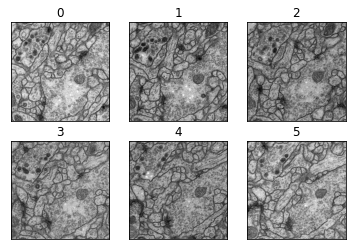

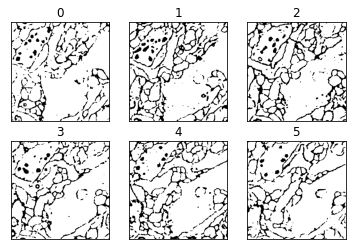

In [36]:
image_path = "src/datasets/ISBI/test_imgs/"
pred_path = "src/predict/"

image_list = os.listdir(image_path)
pred_list = os.listdir(pred_path)

test_image = np.array([cv2.imread(image_path + image_list[p], -1) for p in range(len(image_list))])
pred_masks = np.array([cv2.imread(pred_path + pred_list[p], -1) for p in range(len(pred_list))])

show_image(test_image, num = 6)
show_image(pred_masks, num = 6)